<a href="https://colab.research.google.com/github/Salma-Kassem/DeepLearning/blob/main/prof_training_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!!pip install -Uq git+https://github.com/keras-team/keras-hub.git
!!pip install -Uq keras

['\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.4 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b1.4/1.4 MB\x1b \x1b52.0 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.4/1.4 MB\x1b \x1b33.2 MB/s\x1b eta \x1b0:00:00\x1b',
 "\x1b[?25h\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.22.0.dev0 which is incompatible.\x1b\x1b',
 '\x1b']

In [ ]:
!pip install -q kagglehub



In [ ]:
# Upload kaggle.json (do this manually in Colab)
from google.colab import files
files.upload()  # upload kaggle.json here

# Rename to 'kaggle.json' and move to the correct location
!mkdir -p ~/.kaggle
!mv kaggle_.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle_.json to kaggle_.json


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d lgg_dataset


Streaming output truncated to the last 5000 lines.
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg_dataset/lgg-mri-segmentation/kaggle_3m/TCG

Loaded 3929 image-mask pairs.
Images shape: (3929, 128, 128, 3)
Masks shape: (3929, 128, 128, 1)


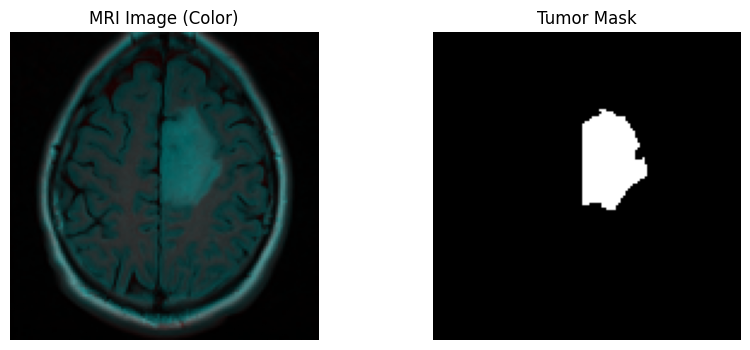

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Set dataset directory (update path if needed)
data_dir = '/content/lgg_dataset/lgg-mri-segmentation/kaggle_3m'

# Resize target
IMG_SIZE = 128# uniformity and to reduce computational load.

# Containers for images and masks
#Empty Python lists to store all processed MRI images and masks.
images = []
masks = []

# Iterate through all patient folders (skip files)
for patient_folder in os.listdir(data_dir):
    patient_path = os.path.join(data_dir, patient_folder)

    if not os.path.isdir(patient_path):
        continue  # Skip if not a directory (e.g., files like data.csv)

    files = os.listdir(patient_path)
    image_files = sorted([f for f in files if f.endswith('.tif') and 'mask' not in f])
    mask_files = sorted([f for f in files if f.endswith('_mask.tif')])

    for img_name, mask_name in zip(image_files, mask_files):
        # Full path
        img_path = os.path.join(patient_path, img_name)
        mask_path = os.path.join(patient_path, mask_name)

        # Load the image in color (BGR) and convert to RGB
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize both image and mask
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Normalize image and mask
        image = image / 255.0
        mask = mask / 255.0
        mask = np.where(mask > 0.5, 1, 0)  # Binarize mask Any pixel value above 0.5 → 1 (tumor)
        #Otherwise → 0 (background)

        # Append to lists
        images.append(image)
        masks.append(mask)

# Convert lists to NumPy arrays
images = np.array(images)  # shape: (num_samples, IMG_SIZE, IMG_SIZE, 3)
masks = np.expand_dims(np.array(masks), axis=-1)  # shape: (num_samples, IMG_SIZE, IMG_SIZE, 1)

print(f"Loaded {len(images)} image-mask pairs.")
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

# Visualize a random example
idx = random.randint(0, len(images) - 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[idx])
plt.title("MRI Image (Color)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masks[idx].squeeze(), cmap='gray')
plt.title("Tumor Mask")
plt.axis('off')

plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# 1. Split into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train images: {X_train.shape}, Train masks: {Y_train.shape}")
print(f"Validation images: {X_val.shape}, Validation masks: {Y_val.shape}")

# 2. Optional: Create tf.data.Dataset objects (for better performance)
batch_size = 64

def create_dataset(images, masks, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    if augment:
        # Define augmentation function here if you want (flip, rotate, etc)
        def augment_fn(img, mask):
            # Example: random horizontal flip
            if tf.random.uniform(()) > 0.5:
                img = tf.image.flip_left_right(img)
                mask = tf.image.flip_left_right(mask)
            return img, mask
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, Y_train, batch_size, augment=True)
val_dataset = create_dataset(X_val, Y_val, batch_size, augment=False)

print(f"Train dataset batches: {len(train_dataset)}")
print(f"Validation dataset batches: {len(val_dataset)}")


Train images: (3143, 128, 128, 3), Train masks: (3143, 128, 128, 1)
Validation images: (786, 128, 128, 3), Validation masks: (786, 128, 128, 1)
Train dataset batches: 50
Validation dataset batches: 13


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)#.repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = val_dataset.take(3000).batch(BATCH_SIZE)
test_batches = val_dataset.skip(3000).take(669).batch(BATCH_SIZE)

## **Build U-Net Model**

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64, 64,    │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_16[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32, 32,    │          0 │ max_pooling2d_9[… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_17[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 16, 16,    │          0 │ max_pooling2d_10… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ dropout_18[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 8, 8, 512) │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 8, 8, 512) │          0 │ max_pooling2d_11

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)